C:\Users\shyam\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shyam\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shyam\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shyam\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dty

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 645 samples, validate on 215 samples
Epoch 1/1000
645/645 [==============================] - 1s 1ms/sample - loss: 0.6936 - binary_accuracy: 0.4930 - auc: 0.5000 - val_loss: 0.6930 - val_binary_accuracy: 0.5302 - val_auc: 0.5000
Epoch 2/1000
645/645 [==============================] - 0s 245us/sample - loss: 0.6936 - binary_accuracy: 0.4930 - auc: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5302 - val_auc: 0.5000
Epoch 3/1000
645/645 [==============================] - 0s 231us/sample - loss: 0.6935 - binary_accuracy: 0.4930 - auc: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5302 - val_auc: 0.5000
Epoch 4/1000
645/645 [==============================] - 0s 231us/sample - loss: 0.6935 - binary_accuracy: 0.4930 - auc: 0.4867 - val_loss: 0.6932 - val_binary_acc

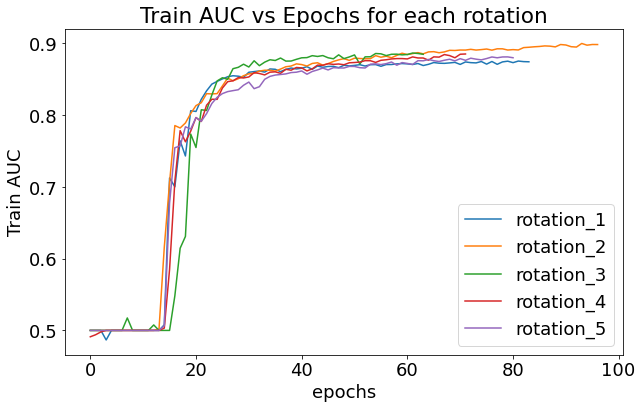

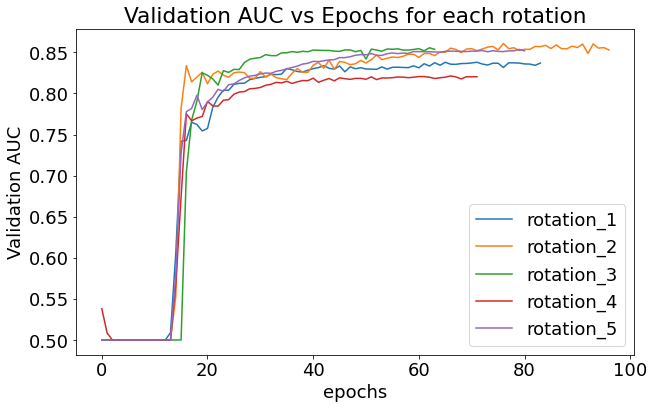

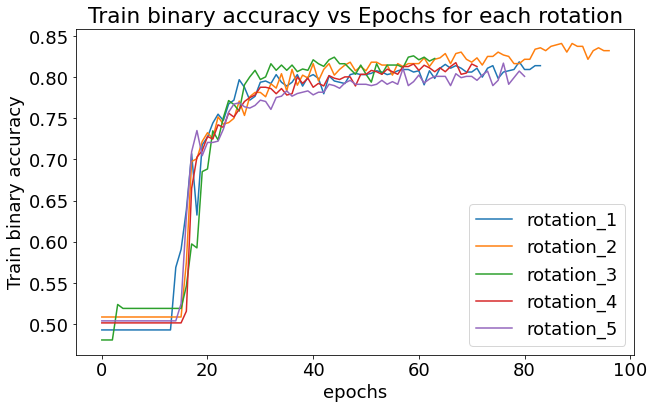

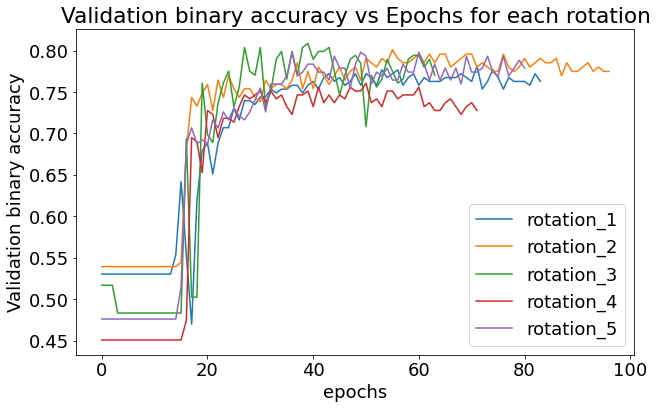

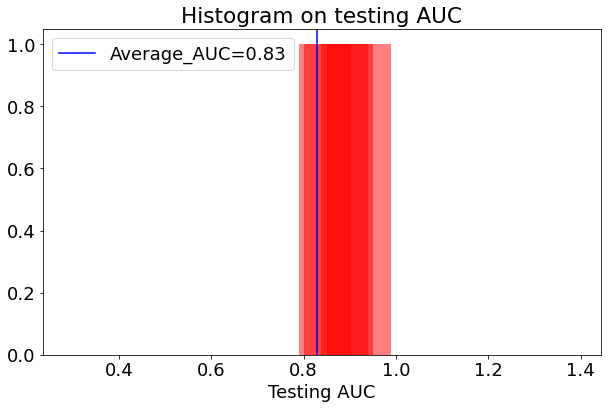

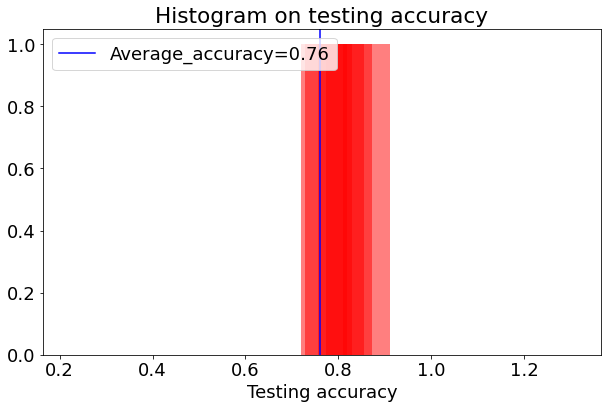

In [1]:
import pandas as pd
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, LeakyReLU, Input, GRU, Embedding
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model
from statistics import mean

import random

import re
import hla_support
import metrics_binarized

##################
def Binary_prediction(label, threshold):
    for i in range(label.shape[0]):
        if label[i] >= threshold:
            label[i] = 1
        else:
            label[i] = 0
    return label

def RNN_network(n_tokens,len_max,ins_train,outs_train,bin_accuracy,
                  auc, n_neurons, 
                   activation, 
                   activation_dense, 
                   lambda_regularization,
               use_gru=False):
    
    # intializing the lambda
    if lambda_regularization is not None:
        lambda_regularization=tf.keras.regularizers.l2(lambda_regularization)
    
    model = Sequential(name = 'Recurrent')
    
    #Embedding layer
    model.add(Embedding(n_tokens,ins_train.shape[1], input_length=len_max))
    
    #RNN layer
    if use_gru:
        model.add(GRU(n_neurons,
                      activation=activation,
                      use_bias=True,
                      return_sequences=False,
                      kernel_initializer='random_uniform',
                      bias_initializer='random_uniform',
                      kernel_regularizer=lambda_regularization,
                      unroll=True))
    else:
        model.add(SimpleRNN(n_neurons,
                      activation=activation,
                      use_bias=True,
                      return_sequences=False,
                      kernel_initializer='random_uniform',
                      bias_initializer='random_uniform',
                      kernel_regularizer=lambda_regularization,
                      unroll=True))
    
    
    #dense layer
    model.add(Dense(units=n_neurons,
                      activation=activation_dense,
                      use_bias=True,
                      kernel_initializer='random_uniform',
                      bias_initializer='random_uniform',
                      kernel_regularizer=lambda_regularization))
    
    model.add(Dense(units=n_neurons//2,
                      activation=activation_dense,
                      use_bias=True,
                      kernel_initializer='random_uniform',
                      bias_initializer='random_uniform',
                      kernel_regularizer=lambda_regularization))
    
    #output layer
    model.add(Dense(units=1,
                      activation='sigmoid',
                      use_bias=True,
                      kernel_initializer='random_uniform',
                      bias_initializer='random_uniform',
                      kernel_regularizer=lambda_regularization))
    
    
    # The optimizer determines how the gradient descent is to be done
    opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, 
                            epsilon=None, decay=0.0, amsgrad=False)
    
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[bin_accuracy , auc])
    
    return model
    
if __name__ == "__main__":
    
    # Default tick label size
    # Default plotting parameters
    FIGURESIZE=(10,6)
    FONTSIZE=18

    plt.rcParams['figure.figsize'] = FIGURESIZE
    plt.rcParams['font.size'] = FONTSIZE

    plt.rcParams['xtick.labelsize'] = FONTSIZE
    plt.rcParams['ytick.labelsize'] = FONTSIZE
    
    thre = 0.426
    
    fi = []
    eva = []
    
    for fold in range(1,6):
        # splits the dataset into train, validation and test
        tokenizer, len_max, n_tokens, ins_train, outs_train, ins_valid, outs_valid, ins_test, outs_test = hla_support.prepare_data_set(fold)

        #converts the labels to 0 and 1
        outs_train = Binary_prediction(outs_train, thre)
        outs_valid = Binary_prediction(outs_valid,thre)
        outs_test = Binary_prediction(outs_test, thre)
        
        #initializing the metrics
        bin_accuracy = tf.keras.metrics.BinaryAccuracy()
        auc = tf.keras.metrics.AUC()
        
        #building the model
        model = RNN_network(n_tokens,len_max,ins_train,outs_train,bin_accuracy,auc, n_neurons=40, activation='tanh', activation_dense='elu', lambda_regularization=0.0001)
        
        # Callbacks
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True,min_delta=0.001)
        
        
        #fitting the model
        history = model.fit(x=ins_train,y=outs_train,batch_size=32,epochs=1000,validation_data=(ins_valid,outs_valid),callbacks=[early_stopping_cb])
        
        
        
        #model evaluate 
        evalu = model.evaluate(ins_test, outs_test)
        
        #storing the work for each fold
        fi.append(history.history)
        eva.append(evalu)
        
    
    #model summary
    print(model.summary())
    
    #plot model
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    #figure 1
    for i in range(5):
        if i > 0:
            plt.plot(fi[i]["auc_"+str(i)], label="rotation_"+str(i+1))
        else:
            plt.plot(fi[i]["auc"], label="rotation_"+str(i+1))
    
    plt.ylabel('Train AUC')
    plt.xlabel('epochs')
    plt.title('Train AUC vs Epochs for each rotation')
    plt.legend()
    plt.savefig("Training_AUC.png")
    plt.show()
    plt.close()
    
    #figure 2
    for i in range(5):
        if i > 0:
            plt.plot(fi[i]["val_auc_"+str(i)], label="rotation_"+str(i+1))
        else:
            plt.plot(fi[i]["val_auc"], label="rotation_"+str(i+1))
    
    plt.ylabel('Validation AUC')
    plt.xlabel('epochs')
    plt.title('Validation AUC vs Epochs for each rotation')
    plt.legend()
    plt.savefig("Validation_AUC.png")
    plt.show()
    plt.close()
    
    #figure 3
    for i in range(5):
        plt.plot(fi[i]["binary_accuracy"], label="rotation_"+str(i+1))
    
    plt.ylabel('Train binary accuracy')
    plt.xlabel('epochs')
    plt.title('Train binary accuracy vs Epochs for each rotation')
    plt.legend()
    plt.savefig("Training_bin_acc.png")
    plt.show()
    plt.close()
    
     #figure 4
    for i in range(5):
        plt.plot(fi[i]["val_binary_accuracy"], label="rotation_"+str(i+1))
    
    plt.ylabel('Validation binary accuracy')
    plt.xlabel('epochs')
    plt.title('Validation binary accuracy vs Epochs for each rotation')
    plt.legend()
    plt.savefig("Validation_bin_acc.png")
    plt.show()
    plt.close()
    
    #finding the average AUC and accuracy
    av_auc=[]
    av_acc=[]
    for i in range(5):
        av_acc.append(eva[i][1])
        av_auc.append(eva[i][2])
    
    avg_acc = round(mean(av_acc),2)
    avg_auc = round(mean(av_auc),2)
    
    #figure 5
    for i in range(5):
        plt.hist(av_auc[i],alpha=0.5,color='red')
    plt.axvline(x = avg_auc, color='b', label = "Average_AUC="+str(avg_auc))
    plt.xlabel('Testing AUC')
    plt.title('Histogram on testing AUC')
    plt.legend()
    plt.savefig("histogram_auc.png")
    plt.show()
    plt.close()
    
    #figure 6
    for i in range(5):
        plt.hist(av_acc[i],alpha=0.5,color='red')
    plt.axvline(x = avg_acc, color='b', label = "Average_accuracy="+str(avg_acc))
    plt.xlabel('Testing accuracy')
    plt.title('Histogram on testing accuracy')
    plt.legend()
    plt.savefig("histogram_accuracy.png")
    plt.show()
    plt.close()
    
    